In [1]:
import numpy as np

import astropy.units as u
import astropy.time as time
import astropy.coordinates as coord

import matplotlib.pyplot as plt

from affine_fitter import AffineTransformFitter
import affine_utils

np.random.seed(0)
%matplotlib inline

# Heliocentric to Geocentric Ecliptic coordinate system

Take a bounding box region in heliocentric and transform it to geocentric coordinate systems. Compare the shapes and locations of bounding boxes in heliocentric and geocentric systems at different sizes, different timestamps, different distances from the Sun and different heliocentric latitudes. 

Obviously biggest difference will be, essentially the parallax created by Earth's motion, so let's just do that real quick and move on.

In [2]:
tno_lon = 30*u.degree
tno_lat = 30*u.degree
tno_d = 80*u.au

# Imagined TNO in heliocentric coordinates
tno_hel = coord.HeliocentricTrueEcliptic(lon=tno_lon, lat=tno_lat, distance=tno_d)

# Imagined timestamp of the observation isot format = YYYY-MM-DDTHH:MM:SS. sss
obs_time1 = time.Time("2022-01-01T00:00:00", format="isot", scale="utc")

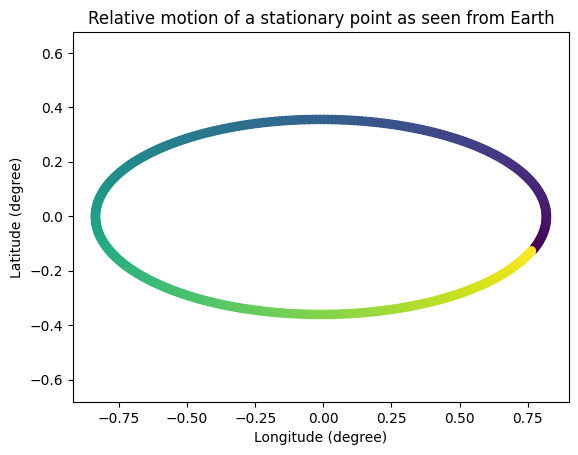

In [3]:
# An array of 365 days of 2022
obs_times = []
for i in range(0, 365):
    obs_times.append(obs_time1 + i*u.day)

# Convert to geocentric ecliptic for each date
tno_geo = []
for t in obs_times:
    geo_eclip_frame = coord.GeocentricTrueEcliptic(obstime=t)
    tno_geo.append(tno_hel.transform_to(geo_eclip_frame))

# make a plot relative to whatever initial heliocentric lon and lats
# we picked and normalize times for color scheme
max_mjd = obs_times[-1].mjd
lons, lats, times = [], [], []
for gt, t in zip(tno_geo, obs_times):
    lons.append((tno_lon - gt.lon).degree)
    lats.append((tno_lat - gt.lat).degree)
    times.append(t.mjd/max_mjd)

fig, ax = plt.subplots()
ax.set_title("Relative motion of a stationary point as seen from Earth")
ax.scatter(lons, lats, c=times)
ax.set_xlabel("Longitude (degree)")
ax.set_ylabel("Latitude (degree)")
ax.set_xlim(-0.8, 0.8)
ax.set_ylim(-0.8, 0.8)
ax.axis("equal")
plt.show()

# Bounding boxes in Heliocentric Ecliptic coordinate system

Obviously, in the above example, the params of the ellipse will be different for different latitudes. What we're interested in are bounding boxes. The above elipse is interesting because it should describe the motion of the center of a stationary bounding box as seen from Earth but what would the sides of a bounding box look like if we transformed it in the same way as a point?

Would the shape, size orientation etc of the bounding box be preserved at different sizes of the bounding box?

In [4]:
box_size = 0.5 * u.degree

# create a square bounding box in heliocentric coord sys around the center of our TNO
start, stop = (tno_lon-box_size).value, (tno_lat+box_size).value
sample = []
for i in np.arange(29.5, 30.5, 0.05):
    sample.append([29.5, i])
    sample.append([30.5, i])
    sample.append([i, 29.5])
    sample.append([i, 30.5])
sample = np.array(sample)

bbox_hel = coord.HeliocentricTrueEcliptic(lon=sample[:, 0]*u.degree, lat=sample[:, 1]*u.degree, distance=80*u.au)

In [5]:
# pick another date, 6 months after the first observation
obs_time2 = obs_time1 + 182*u.day

# convert the bounding box coords to geocentric coords at these two timestamps
geo_eclip_frame1 = coord.GeocentricTrueEcliptic(obstime=obs_time1)
geo_eclip_frame2 = coord.GeocentricTrueEcliptic(obstime=obs_time2)

bbox_geo1 = bbox_hel.transform_to(geo_eclip_frame1)
bbox_geo2 = bbox_hel.transform_to(geo_eclip_frame2)

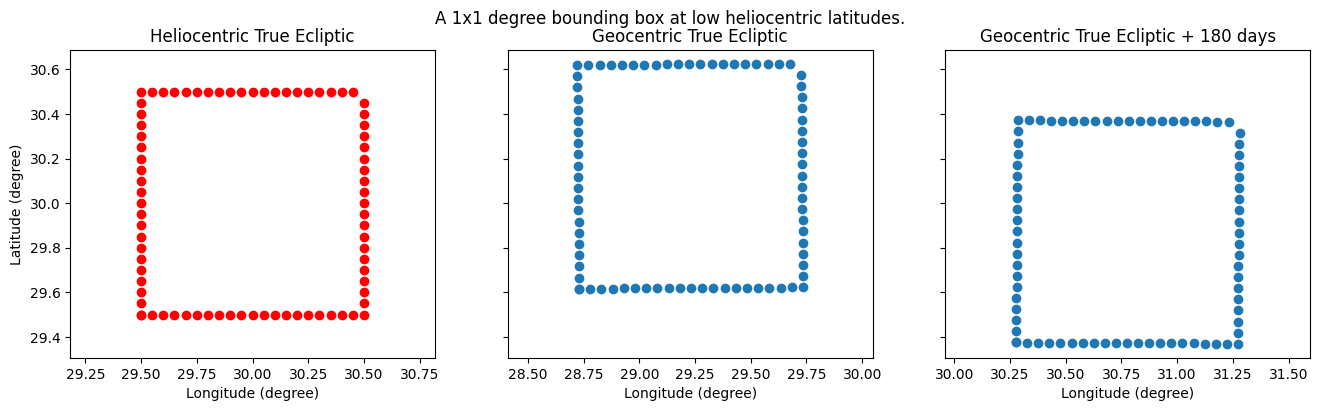

In [6]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
axes[0].scatter(bbox_hel.lon, bbox_hel.lat, color="red")
axes[1].scatter(bbox_geo1.lon, bbox_geo1.lat)
axes[2].scatter(bbox_geo2.lon, bbox_geo2.lat)

axes[0].set_title("Heliocentric True Ecliptic")
axes[1].set_title("Geocentric True Ecliptic")
axes[2].set_title("Geocentric True Ecliptic + 180 days")
axes[0].set_ylabel("Latitude (degree)")
for ax in axes:
    ax.set_xlabel("Longitude (degree)")
    ax.axis("equal")
    
_ = fig.suptitle("A 1x1 degree bounding box at low heliocentric latitudes.")

Let's do it for different bbox sizes and heliocentric latitudes. The function `affine_utils.plot_bbox_t_t180` is essentially the same code as above.

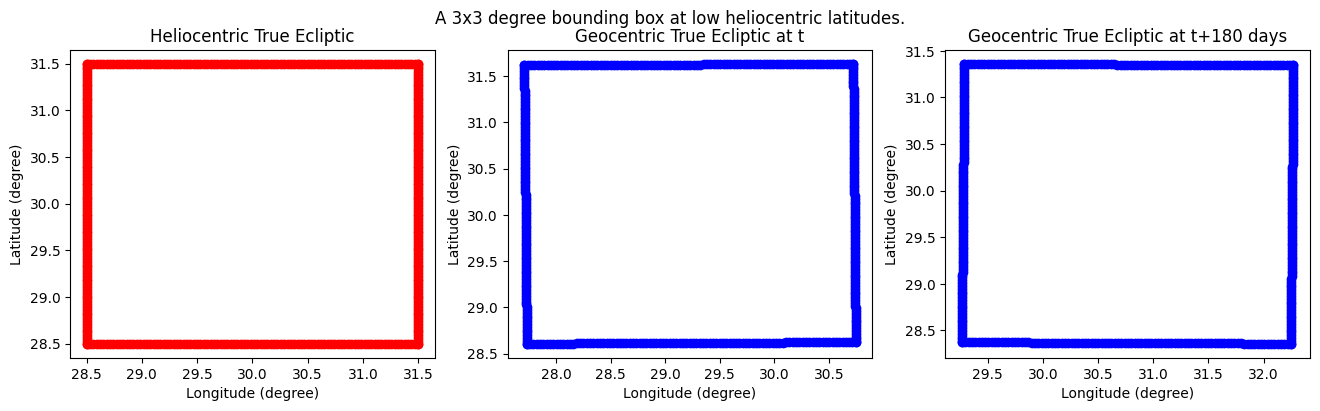

In [7]:
fig, axes = affine_utils.plot_bbox_t_t180(
    tno_hel, 
    obs_time1,
    bbox_size=3*u.degree,
    n_samples=100,
    aspect_ratio="equal"
)

_ = fig.suptitle("A 3x3 degree bounding box at low heliocentric latitudes.")

In [8]:
# A wild TNO has appeared! It uses "high latitude".
tno_hel2 = coord.HeliocentricTrueEcliptic(lon=tno_lon, lat=80*u.degree, distance=tno_d)

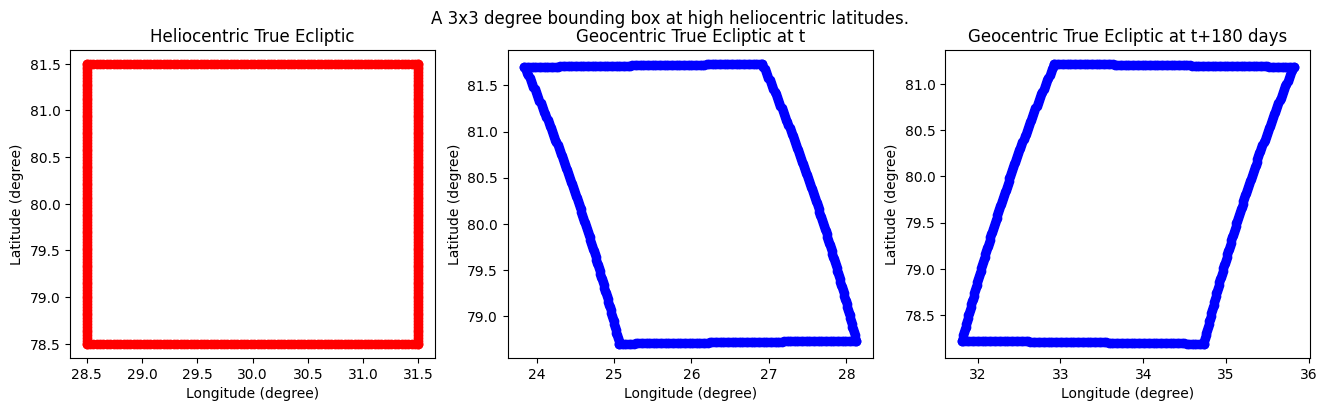

In [9]:
fig, axes = affine_utils.plot_bbox_t_t180(
    tno_hel2, 
    obs_time1,
    bbox_size=3*u.degree,
    n_samples=100,
    aspect_ratio="equal"
)

_ = fig.suptitle("A 3x3 degree bounding box at high heliocentric latitudes.")

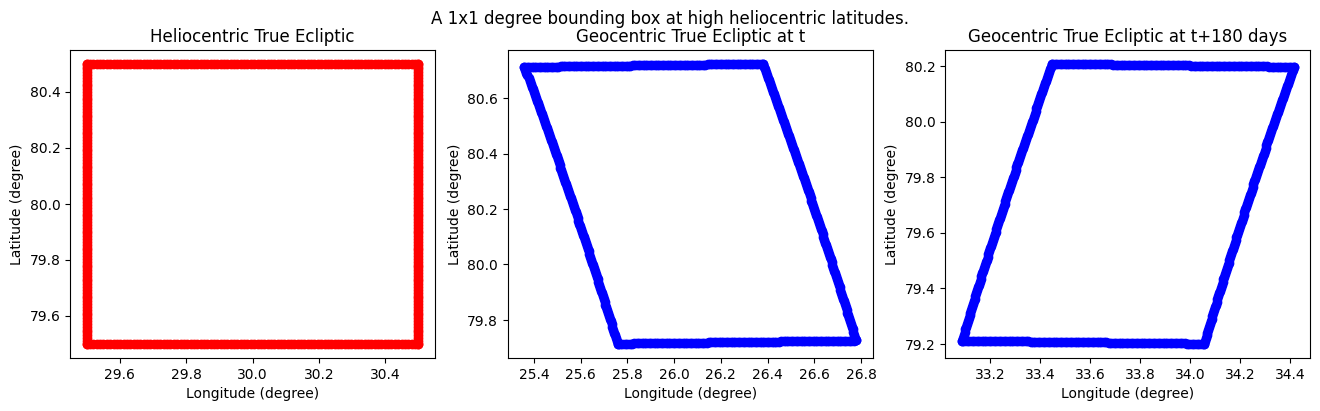

In [10]:
tno_hel2 = coord.HeliocentricTrueEcliptic(lon=tno_lon, lat=80*u.degree, distance=tno_d)
fig, axes = affine_utils.plot_bbox_t_t180(
    tno_hel2, 
    obs_time1,
    bbox_size=1*u.degree,
    n_samples=100,
)

_ = fig.suptitle("A 1x1 degree bounding box at high heliocentric latitudes.")

# Affine transform

At low latitudes the bounding box seems mostly translated and rotated. This is good because these are linear transformations which are easy to compute. Since the plots are somewhat small and the units are degrees, and we're looking to have an arcsecond precision, the plots might be deceiving. 

At high latitudes large bounding boxes have obvious non-linear distorsions, however, even at 1x1 degree the bounding box seems somewhat linear. 

The interesting question now is - given that these are large-ish plots in degrees - how big is that distorsion and is it on the order of < 1 arcsecond?

The way I'm going to attempt to answer this question is by: 
* fitting an affine transform (scale, rotation, shear and translation) of the "perfect" square (heliocentric bounding box) to the projected geocentric distorted square, and then
* measuring the angular separation of each projected point to its originator

First an example on a 1x1 degree bounding box at low heliocentric latitudes, the same one we started the notebook with.       
Heliocentric bounding box (red) is plotted in the same space as the geocentric bounding box (blue). An affine transfrom of the red bounding box is fitted to that of the blue bounding box, in green. This translates, skewes, scales and shears the red box to make it match the blue box. How close that matching is depends on 2 things:
* how non-linearly distorted is the blue box and
* how good is the fit

The left-hand plot is the zoom-in on the top left corner of the blue box, showing the miss-match of the fitted affine transform (green) and the geocentric coordinates.

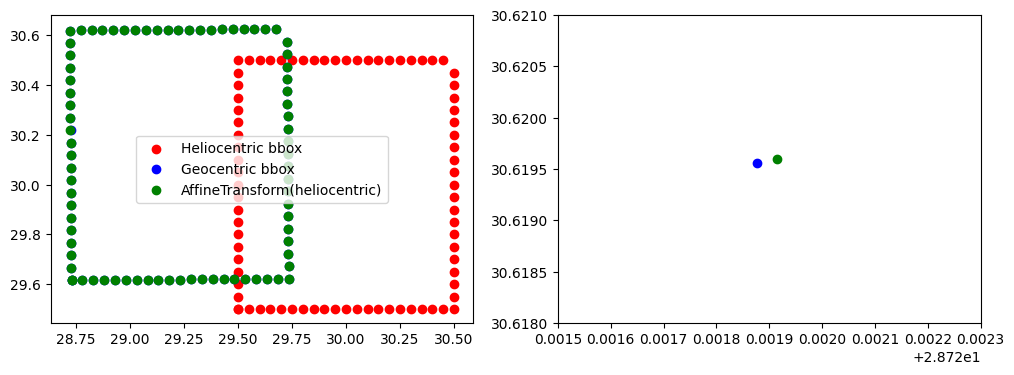

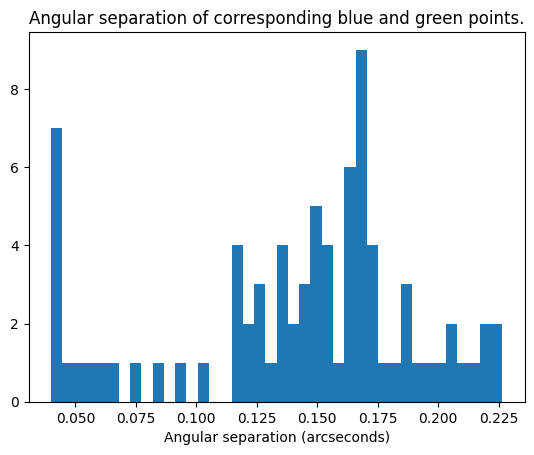

In [11]:
afft = AffineTransformFitter(
    np.array([bbox_hel.lon.degree, bbox_hel.lat.degree]),
    np.array([bbox_geo1.lon.degree, bbox_geo1.lat.degree])
)
fit = afft.fit()
transformed = afft.transform()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(bbox_hel.lon, bbox_hel.lat, color="red", label="Heliocentric bbox")
axes[0].scatter(bbox_geo1.lon, bbox_geo1.lat, color="blue", label="Geocentric bbox")
axes[0].scatter(transformed[0], transformed[1], color="green", label="AffineTransform(heliocentric)")
axes[0].legend()
axes[1].scatter(bbox_geo1.lon, bbox_geo1.lat, color="blue", label="Geocentric bbox")
axes[1].scatter(transformed[0], transformed[1], color="green", label="AffineTransform(heliocentric)")
axes[1].set_xlim(28.7215, 28.7223)
axes[1].set_ylim(30.618, 30.621)

# Afft transforms first set of points into the second. In this case square1
# into square2, i.e. we look at distance between square2 and transform
dists = coord.angular_separation(
    bbox_geo1.lon.radian,
    bbox_geo1.lat.radian,
    (transformed[0]*u.degree).to(u.radian).value,
    (transformed[1]*u.degree).to(u.radian).value
)
dists_arcsec = (dists*u.radian).to(u.arcsecond)

fig, ax = plt.subplots()
ax.hist(dists_arcsec.value, bins=40)
ax.set_title("Angular separation of corresponding blue and green points.")
_ = ax.set_xlabel("Angular separation (arcseconds)")

Different initial distances, bounding box sizes, heliocentric latitudes and time steps will make an impact on the angular separation of the geocentric coordinates and an affine transform of the heliocentric ones. 

Distance, for example, will mainly affect the parallax the object is seen from the Earth, i.e. translation required to properly register the bounding boxes, so it's less interesting to focus on than, for example, the size of the bounding box and the latitude of its center pixel. 

It appears as if the distorsion for a 1x1 degree bounding box at low-ish latitudes are not appreciable. The estimate I found was that the PSF FWHM for LSST is 0.4" and the seeing 0.7". I could not find the total PSF FWHM (a convolution of the two) but given the two estimates it's at least 0.7".

Let's look at the same 1x1 and 3x3 degree sized bounding boxes at 30 and 80 degrees of latitude as in the first section, but this time on the same plot to verify that the fits are correct. 

In [12]:
helio_center = tno_hel2
cast_units = "degree"
n_samples=5000
bbox_size=3*u.degree
obs_t = obs_time1

# source
bbox_helios = [
    affine_utils.make_heliocentric_bbox(tno_hel, bbox_size=1*u.degree),  # 1x1 at 30deg lat
    affine_utils.make_heliocentric_bbox(tno_hel2, bbox_size=1*u.degree), # 1x1 at 80deg lat
    affine_utils.make_heliocentric_bbox(tno_hel, bbox_size=3*u.degree),  # 3x3 at 30 lat
    affine_utils.make_heliocentric_bbox(tno_hel2, bbox_size=3*u.degree), # 3x3 at 80 lat
]

# target box is the source box transformed to geocentric
bbox_geos = [
    affine_utils.geocentric_bbox_from_heliocentric(tno_hel, obs_time1, bbox_size=1*u.degree),
    affine_utils.geocentric_bbox_from_heliocentric(tno_hel2, obs_time1, bbox_size=1*u.degree),
    affine_utils.geocentric_bbox_from_heliocentric(tno_hel, obs_time1, bbox_size=3*u.degree),
    affine_utils.geocentric_bbox_from_heliocentric(tno_hel2, obs_time1, bbox_size=3*u.degree)
]


fits = [
    affine_utils.fit_affine(bh, bg) for bh, bg in zip(bbox_helios, bbox_geos)
]

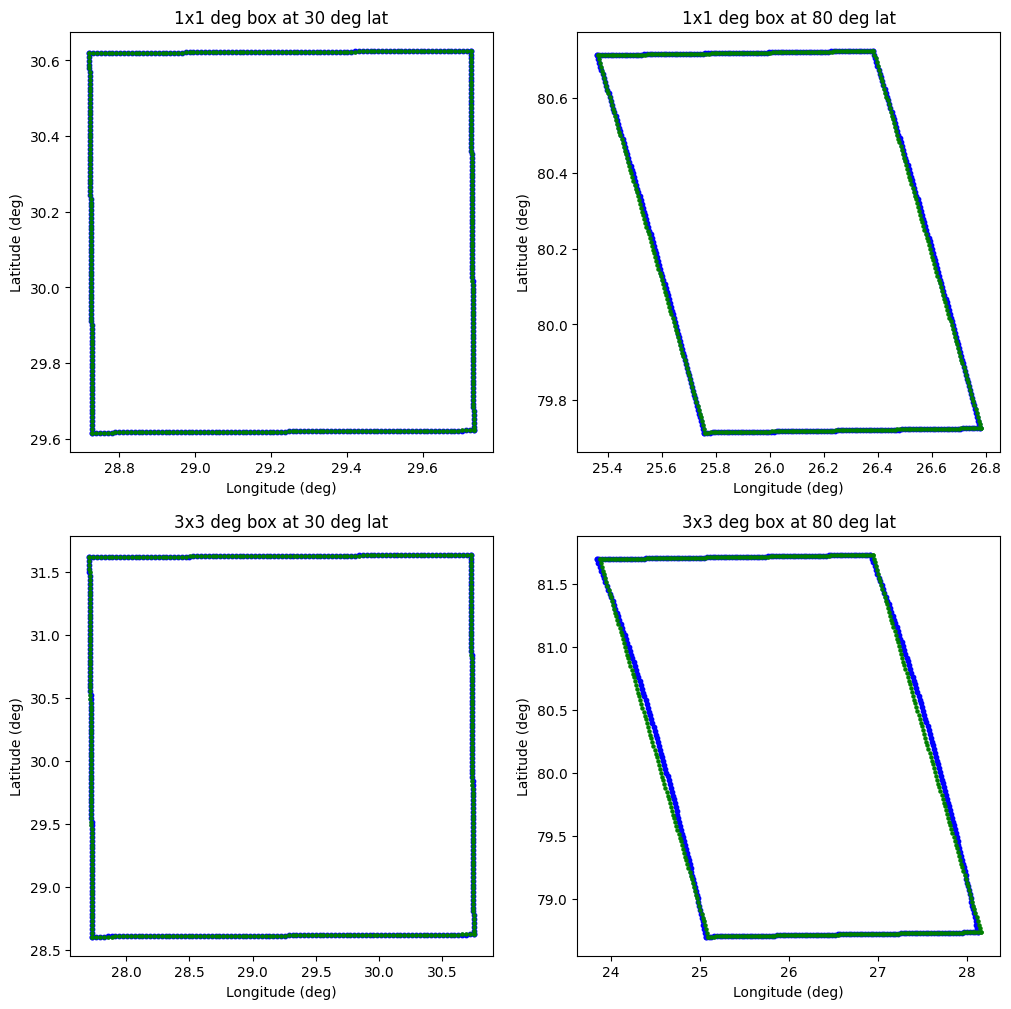

In [13]:
def plt_fits(afft, transformed, distances, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    #ax.scatter(*afft.points1.mean(axis=1), color="red")
    ax.scatter(afft.points2[0], afft.points2[1], color="blue", s=10)
    ax.scatter(transformed.lon, transformed.lat, color="green", s=5)
    
titles = [
    "1x1 deg box at 30 deg lat",
    "1x1 deg box at 80 deg lat",
    "3x3 deg box at 30 deg lat",
    "3x3 deg box at 80 deg lat"
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for ax, fit, title in zip(axes.ravel(), fits, titles):
    plt_fits(*fit, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Longitude (deg)")
    ax.set_ylabel("Latitude (deg)")

Looks great, let's check at arcsec level.

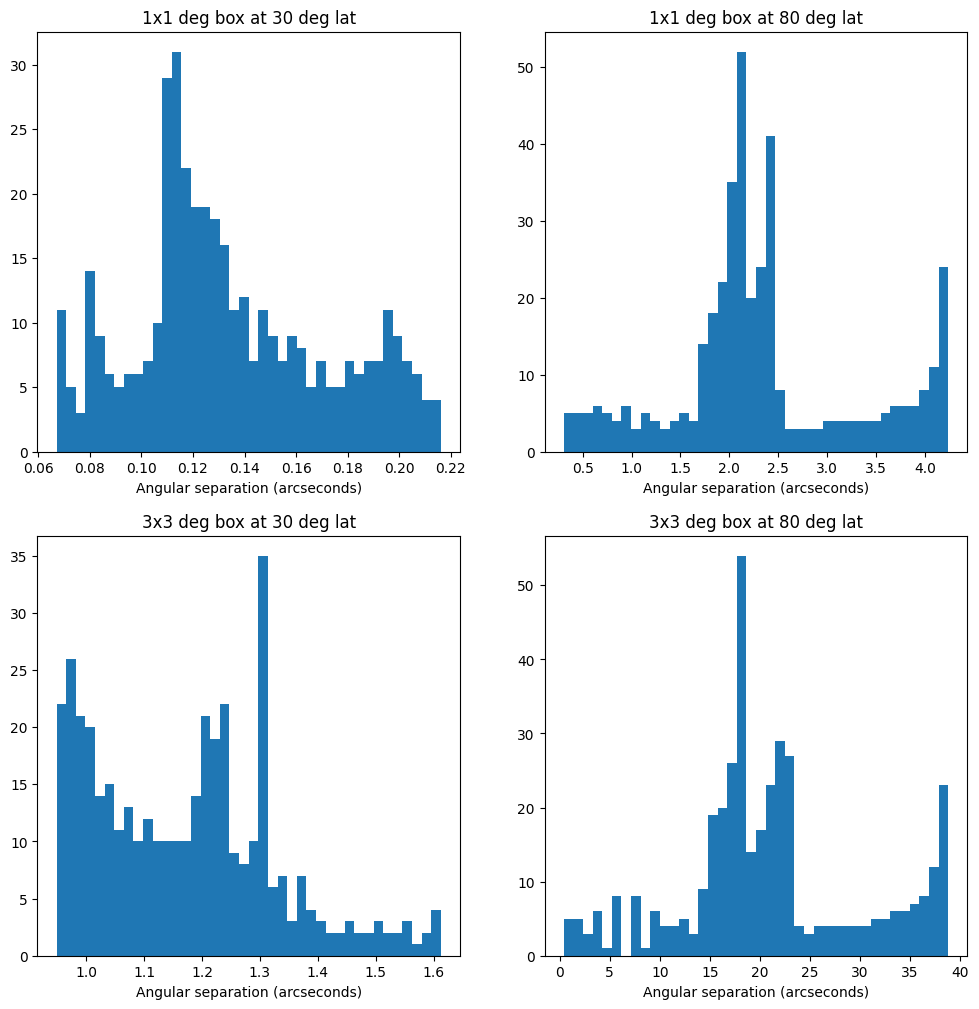

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for ax, fit, title in zip(axes.ravel(), fits, titles):
    ax.hist(fit[2].value, bins=40)
    ax.set_title(title)
    ax.set_xlabel("Angular separation (arcseconds)")

Ok, not that great. Let's try and figure out why.

## Fit precission

Before we assume the worse (that the distorsions are 100% due to geometry), let's gauge how much can of that can be taken off the top by a different fit cost metric and/or more iterations etc. 

First, let's look at some base stats for 1x1 deg box at 80 deg lat:

In [15]:
def print_stats(fit):
    print(f"Mean distances: {fit[2].mean()}")
    print(f"Center points1 {fit[0].points1.mean(axis=1)}")
    print(f"Center points1 {fit[0].points2.mean(axis=1)}")
    print("Fit: ")
    print(fit[0].bestfit)
    
bboxh = bbox_helios[-1]
bboxg = bbox_geos[-1]
prev_fit = fits[-1]

In [16]:
print_stats(prev_fit)

Mean distances: 20.977131246777752 arcsec
Center points1 [30. 80.]
Center points1 [26.01743622 80.21854796]
Fit: 
     fun: 0.750761891408702
     jac: array([ 0.04176189,  0.11811565,  0.00147685, -0.05903588, -0.15346438,
       -0.00192392])
 message: 'Optimization terminated successfully'
    nfev: 138
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([ 1.02057279e+00, -4.05205180e-01,  2.78166698e+01,  1.17022009e-02,
        9.98305544e-01,  3.03475655e-03])


In [17]:
# this is the value of the last iteration of the minimization function A'-TA = 0 I add it
# here for the purposes of comparing it with minimizations performed in different units
print(f"The fit 'fun' value is approx: {(prev_fit[0].bestfit.fun*u.degree).to(u.arcsecond)}")

The fit 'fun' value is approx: 2702.742809071327 arcsec


So those are our base values to compare to. Let's see if we can do better if we transform everything to arcseconds before minimization (larger numbers, less rounding errors etc.).

In [18]:
afft, transformed, distance  = affine_utils.fit_affine(
    bboxh, 
    bboxg,
    "arcsec"
)
print_stats((afft, transformed, distance))

Mean distances: 20.99034354174215 arcsec
Center points1 [108000. 288000.]
Center points1 [ 93662.77040725 288786.7726552 ]
Fit: 
     fun: 2702.767226087463
     jac: array([2.76356201e+01, 7.58253174e+01, 2.44140625e-04, 1.43706207e+02,
       3.89074951e+02, 2.28881836e-03])
 message: 'Optimization terminated successfully'
    nfev: 283
     nit: 33
    njev: 33
  status: 0
 success: True
       x: array([ 1.02057619e+00, -4.05203755e-01,  1.00139224e+05,  1.16669304e-02,
        9.98208580e-01,  4.26887878e+01])


Nope. How about different cost functions.

In [19]:
afft, transformed, distance = affine_utils.fit_affine(
    bboxh, 
    bboxg,
    costf="L1", 
)
print_stats((afft, transformed, distance))

Mean distances: 19.270548271455844 arcsec
Center points1 [30. 80.]
Center points1 [26.01743622 80.21854796]
Fit: 
     fun: 12.740672436860951
     jac: array([-120.18181801, -314.12121248,   -4.        ,  324.21654701,
       1044.53783703,   10.        ])
 message: 'Optimization terminated successfully'
    nfev: 276
     nit: 30
    njev: 30
  status: 0
 success: True
       x: array([ 1.01996194e+00, -4.05319470e-01,  2.78167529e+01,  1.17327682e-02,
        9.98279419e-01,  4.15501791e-03])


In [20]:
afft, transformed, distance = affine_utils.fit_affine(
    bboxh, 
    bboxg,
    costf="ang_sep"
)
print_stats((afft, transformed, distance))

Mean distances: 19.18706915785509 arcsec
Center points1 [30. 80.]
Center points1 [26.01743622 80.21854796]
Fit: 
     fun: 0.03720861451249194
     jac: array([1.38824258e-01, 3.74870765e-01, 4.46489919e-03, 3.72095783e+00,
       9.68810715e+00, 1.19005964e-01])
 message: 'Optimization terminated successfully'
    nfev: 303
     nit: 36
    njev: 36
  status: 0
 success: True
       x: array([ 1.01853100e+00, -4.01515119e-01,  2.75591079e+01,  1.16638780e-02,
        9.98317051e-01,  3.08942146e-03])


Both L1 and angular separation cost function outperform the base-fit by ~2 arcseconds. How about if we mess with precission tolerances? 

In [21]:
# this will run for a while, might want to comment it out 
afft, transformed, distance = affine_utils.fit_affine(
    bboxh, 
    bboxg,
    costf="ang_sep", 
    tol=1e-15,
    options={"maxiter": 15000}
)
print_stats((afft, transformed, distance))

Mean distances: 19.18472559902903 arcsec
Center points1 [30. 80.]
Center points1 [26.01743622 80.21854796]
Fit: 
     fun: 0.037204069754966505
     jac: array([ 0.18734112,  0.5070922 ,  0.00638732, -0.02444752,  0.11090379,
        0.00087357])
 message: 'Iteration limit reached'
    nfev: 254637
     nit: 15000
    njev: 15000
  status: 9
 success: False
       x: array([ 1.01846889e+00, -4.02373093e-01,  2.76282694e+01,  1.16491394e-02,
        9.98308537e-01,  4.18595330e-03])


Not by much (or at all), which I guess is good since it indicates the fits are at least working, bad since it indicates taht most of that 19arcsec distorsion is real. Fair enough, given that the bbox is 3x3 degrees at 80 deg latitude. A very dificult case.

Two things are interesting here to me: 
 * one, the effects of the better fit options on the 1x1 degree box at 80 deg latitude. Its maximum discrepancy is 4 arcsecond, see histograms above, so if the better cost function can shave off from that it would mean that the point at which we can not see the effects of distorsion on images anymore would be a rather large and 
 * two, what is that size exactly

In [22]:
bboxh = bbox_helios[0]
bboxg = bbox_geos[0]
prev_fit = fits[0]
print_stats(prev_fit)

Mean distances: 0.13403429483466373 arcsec
Center points1 [30. 30.]
Center points1 [29.22819142 30.12073377]
Fit: 
     fun: 0.000831923237650516
     jac: array([ 7.31012097,  8.65561328,  0.19000755, 14.24342801, 14.92447344,
        0.4312803 ])
 message: 'Optimization terminated successfully'
    nfev: 221
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([ 1.0047604 , -0.00781716, -0.68010542,  0.00585214,  1.00360666,
       -0.16302909])


In [23]:
afft, transformed, distance = affine_utils.fit_affine(
    bboxh, 
    bboxg,
    costf="ang_sep"
)
print_stats((afft, transformed, distance))

Mean distances: 0.14586182393986902 arcsec
Center points1 [30. 30.]
Center points1 [29.22819142 30.12073377]
Fit: 
     fun: 0.0002828632311905949
     jac: array([ -6.83114416,  -6.52638099,  -0.23262925, -56.91967612,
       -56.36522641,  -1.90951744])
 message: 'Optimization terminated successfully'
    nfev: 261
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([ 1.00474371, -0.00781803, -0.67958622,  0.00584246,  1.00361753,
       -0.16308303])


Ruh-roh, it's gotten worse! This either means:
* we're probably in a pretty flat place and going a little smaller and little larger doesn't really make a significant different or, the more likely reason,
* I've made a mistake somewhere

Given that the smaller the box is, the distorsion should tend to 0 I would naively be expecting to get smaller and smaller mean and max distances between ecliptic bounding box points untill we start seeing rounding off problems essentialy (or the minimization quits). 

I seem to have the opposite problem, where my fits get worse and worse the smaller I get:

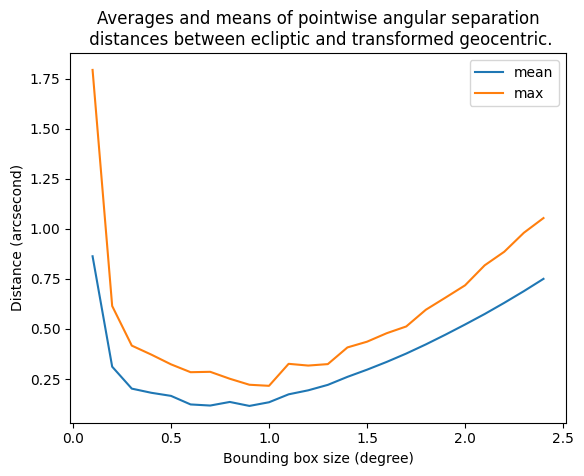

In [24]:
mean_dist, max_dist = [], []
bbox_sizes = np.arange(0.1, 2.5, 0.1)
for bbs in bbox_sizes:
    bboxh = affine_utils.make_heliocentric_bbox(tno_hel, bbox_size=bbs*u.degree)
    bboxg = affine_utils.geocentric_bbox_from_heliocentric(tno_hel, obs_time1, bbox_size=bbs*u.degree)
    afft, transformed, distance = affine_utils.fit_affine(bboxh, bboxg)
    mean_dist.append(distance.mean().value)
    max_dist.append(distance.max().value)
    
plt.plot(bbox_sizes, mean_dist, label="mean")
plt.plot(bbox_sizes, max_dist, label="max")
plt.xlabel("Bounding box size (degree)")
plt.ylabel("Distance (arcsecond)")
plt.title("Averages and means of pointwise angular separation\n distances between ecliptic and transformed geocentric.")
plt.legend()

The confusing bit is that I can't seem to force it in any way to get better for any size smaller than 1 degree, but I can't see any mistakes in my code anymore either. Moving to arcseconds doesn't really help, neither does a change of the cost function, looking at individual fits they seem ok-ish most of the time. Number of samples doesn't really change the results either so it's not a bad normalization scheme or similar...

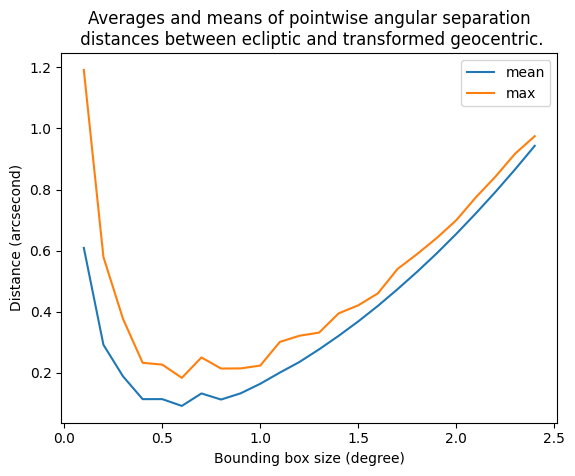

In [25]:
mean_dist, max_dist = [], []
bbox_sizes = np.arange(0.1, 2.5, 0.1)
for bbs in bbox_sizes:
    bboxh = affine_utils.make_heliocentric_bbox(tno_hel, bbox_size=bbs*u.degree, n_samples=2)
    bboxg = affine_utils.geocentric_bbox_from_heliocentric(tno_hel, obs_time1, bbox_size=bbs*u.degree, n_samples=2)
    
    afft, transformed, distance = affine_utils.fit_affine(
        bboxh, 
        bboxg,
        "arcsec", 
        costf="L2", 
        tol=1e-10,
        options={"maxiter": 1000})
    
    mean_dist.append(distance.mean().value)
    max_dist.append(distance.max().value)
    
plt.plot(bbox_sizes, mean_dist, label="mean")
plt.plot(bbox_sizes, max_dist, label="max")
plt.xlabel("Bounding box size (degree)")
plt.ylabel("Distance (arcsecond)")
plt.title("Averages and means of pointwise angular separation\n distances between ecliptic and transformed geocentric.")
plt.legend()